In [22]:
pip install bitmex

In [81]:
import pandas as pd
import math
import time
import os
from tqdm import tqdm
from bitmex import bitmex
from datetime import timedelta
from dateutil import parser
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

from datetime import datetime

In [95]:
class BitMexExporter:

    def __init__(self):
        self.client = bitmex(test=False,
                             api_key=os.environ.get('API_KEY'),
                             api_secret=os.environ.get('API_SECRET'))
        self.binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
        self.batch_size = 20

    def minutes_of_new_data(self, symbol, kline_size, data):
        if len(data) > 0:
            old = parser.parse(data["timestamp"].iloc[-1])
        old = self.client.Trade.Trade_getBucketed(
            symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
        new = self.client.Trade.Trade_getBucketed(
            symbol=symbol, binSize=kline_size, count=1, reverse=False, startTime=datetime.strptime('19/02/28', '%y/%m/%d')).result()[0][0]['timestamp']
        return old, new

    def export(self, symbol, kline_size, save=False):
        filename = '%s-%s-data.csv' % (symbol, kline_size)
        print(filename, '\n')
        if os.path.isfile(filename):
            data_df = pd.read_csv(filename)
        else:
            data_df = pd.DataFrame()
        oldest_point, newest_point = self.minutes_of_new_data(symbol, kline_size, data_df)
        delta_min = (newest_point - oldest_point).total_seconds() / 60
        available_data = math.ceil(delta_min / self.binsizes[kline_size])
        rounds = math.ceil(available_data / self.batch_size)
        if rounds > 0:
            for round_num in tqdm(range(rounds)):
                time.sleep(1)
                new_time = (oldest_point + timedelta(minutes=round_num * self.batch_size * self.binsizes[kline_size]))
                data = self.client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size,
                                                           count=self.batch_size, startTime=new_time).result()[0]
                temp_df = pd.DataFrame(data)
                data_df = data_df.append(temp_df)
        data_df.set_index('timestamp', inplace=True)
        if save and rounds > 0:
            data_df.to_csv(filename)
        return data_df
# sym1 = "ETH"
# sym2 = "USD"
# frec="1d"
# data = BitMexExporter().export(sym1.upper() + sym2.upper(), frec, save=False)
# data = data[:]

In [64]:
data = data[:210]
print(data.filter(["close"]))

                            close
timestamp                        
2018-08-03 00:00:00+00:00  410.80
2018-08-04 00:00:00+00:00  417.70
2018-08-05 00:00:00+00:00  407.05
2018-08-06 00:00:00+00:00  409.15
2018-08-07 00:00:00+00:00  405.60
...                           ...
2019-02-24 00:00:00+00:00  158.10
2019-02-25 00:00:00+00:00  132.20
2019-02-26 00:00:00+00:00  137.55
2019-02-27 00:00:00+00:00  135.85
2019-02-28 00:00:00+00:00  134.30

[210 rows x 1 columns]


In [96]:
class MPPModel:
    def __init__(self, sym1, sym2, frec="1d", batch_size=1, epochs=1):
        self.batch_size = batch_size
        self.epochs = 1
        self.sym1 = sym1
        self.sym2 = sym2
        self.frec = frec if frec in ("1m", "5m", "1h", "1d") else "1d"
        self.model = None
        self.scaler = None
        self.training_data_len = None
        self.data = None
        self.train_ds = None
        self.test_ds = None
        self.predictions = None

    def get_dataset(self, test=True):
        data = BitMexExporter().export(self.sym1.upper() + self.sym2.upper(), self.frec, save=False)
        #self.data = data[:210]
        self.data = data.filter(["close"])
        dataset = self.data.values
        self.training_data_len = math.ceil(len(dataset) * .85)
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = self.scaler.fit_transform(dataset)
        train_data = scaled_data[0:self.training_data_len, :]
        x_train = []
        y_train = []
        for i in range(60, len(train_data)):
            x_train.append(train_data[i - 60: i, 0])
            y_train.append(train_data[i, 0])
        x_train, y_train = np.array(x_train), np.array(y_train)
        x_train = np.reshape(x_train, (x_train.shape[0], 60, 1))
        self.train_ds = (x_train, y_train)
        if test:
            test_data = scaled_data[self.training_data_len - 60:, :]
            x_test = []
            y_test = dataset[self.training_data_len:, :]
            for i in range(60, len(test_data)):
                x_test.append(test_data[i - 60: i, 0])
            x_test = np.array(x_test)
            x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))
            self.test_ds = (x_test, y_test)
            return x_train, y_train, x_test, y_test
        return x_train, y_train

    def evaluate(self):
        if not self.predictions:
            predictions = self.model.predict(self.test_ds[0])
            self.predictions = self.scaler.inverse_transform(predictions)
        rmse = np.sqrt(np.mean(self.predictions - self.test_ds[1]) ** 2)
        print(rmse)

    def build_and_compile(self):
        self.model = Sequential(
            [
                LSTM(50, return_sequences=True, input_shape=(self.train_ds[0].shape[1], 1)),
                LSTM(50, return_sequences=False),
                Dense(25),
                Dense(1)
            ])
        self.model.compile(optimizer="adam", loss="mean_squared_error")
        self.model.summary()

    def train(self):
        x_train, y_train, x_test, y_test = self.get_dataset()
        self.build_and_compile()
        self.model.fit(x_train, y_train, self.batch_size, self.epochs)

    def plot(self):
        if not self.predictions:
            predictions = self.model.predict(self.test_ds[0])
            self.predictions = self.scaler.inverse_transform(predictions)
        train = self.data[:self.training_data_len]
        valid = self.data[self.training_data_len:]
        valid["predictions"] = self.predictions
        plt.style.use("fivethirtyeight")
        plt.figure(figsize=(16, 8))
        plt.title("Model")
        plt.xlabel("Date", fontsize=18)
        plt.ylabel("Close Price %s (%s)" % (self.sym1, self.sym2))
        plt.plot(train["close"])
        plt.plot(valid[["close", "predictions"]])
        plt.legend(["Train", "Val", "Predictions"], loc="lower right")
        plt.show()

/usr/local/lib/python3.7/dist-packages/swagger_spec_validator/validator20.py:52: SwaggerValidationWarning: Found "$ref: #/definitions/UserPreferences" with siblings that will be overwritten. See https://stackoverflow.com/a/48114924 for more information. (path #/definitions/User/properties/preferences)
  ref_dict['$ref'], '/'.join(path),


ETHUSD-1d-data.csv 



100%|██████████| 11/11 [00:13<00:00,  1.27s/it]


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_29 (LSTM)              (None, 50)                20200     
                                                                 
 dense_28 (Dense)            (None, 25)                1275      
                                                                 
 dense_29 (Dense)            (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
127/127 [==============================] - 7s 31ms/step - loss: 0.0063


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


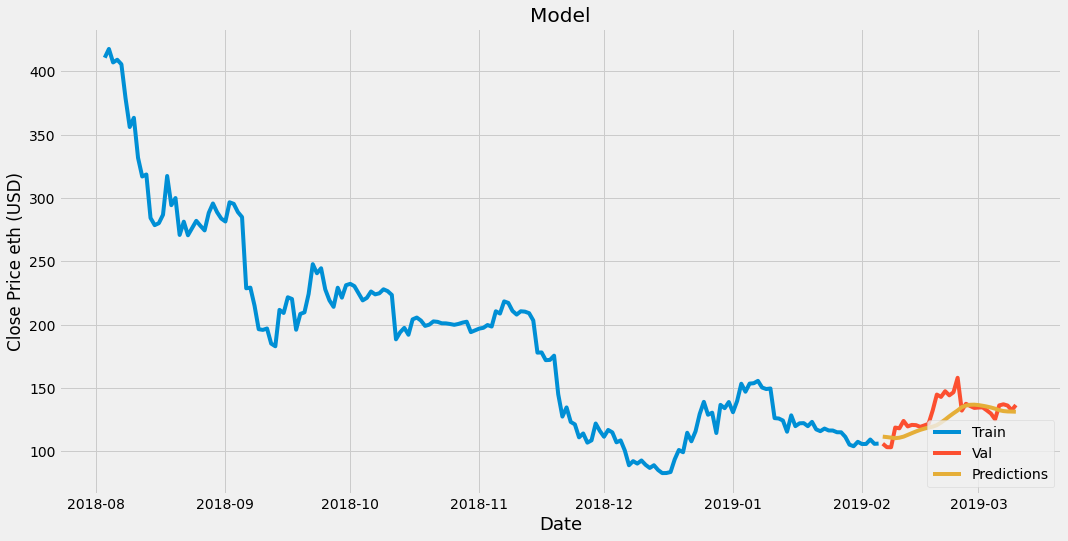

In [97]:
model = MPPModel("eth", "USD", frec="1d", batch_size=1, epochs=3)
model.train()
model.plot()